Imports

In [31]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
import datasets
import pandas as pd
import librosa
import kagglehub
from wavencoder.models.rawnet import RawNet2Model
import torch.optim as optim

OSError: dlopen(/Library/Python/3.9/site-packages/torchaudio/lib/libtorchaudio.so, 0x0006): Symbol not found: __ZN2at4_ops9fft_irfft4callERKNS_6TensorENSt3__18optionalIN3c106SymIntEEExNS6_INS7_17basic_string_viewIcEEEE
  Referenced from: <7CB27178-9CF6-3B2E-BBB0-528F29A2DEBB> /Library/Python/3.9/site-packages/torchaudio/lib/libtorchaudio.so
  Expected in:     <D983C0C6-7C01-3D9C-A96B-07BB20D2CE66> /Users/roeeseren/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib

In [33]:
from utils import load_protocol, plot_results
import data_utils
import audio_utils
import train_utils

In [22]:
# Find the strongest available GPU
if torch.cuda.is_available():
    device = torch.device(f'cuda:{torch.cuda.device_count() - 1}')
elif torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


In [23]:
dataset_path = data_utils.get_data()

In [24]:
col_names = ['speaker', 'file_name', 'attack', 'label']
protocols_folder = "LA/LA/ASVspoof2019_LA_cm_protocols"
protocol_file_prefix = "ASVspoof2019.LA.cm"

data_info_train_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.train.trn.txt"
data_info_val_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.dev.trl.txt"
data_info_test_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.eval.trl.txt"

In [25]:
train_df_info = load_protocol(data_info_train_file_path, names=col_names)
val_df_info = load_protocol(data_info_train_file_path, names=col_names)
test_df_info = load_protocol(data_info_train_file_path, names=col_names)

In [26]:
train_df = data_utils.process_data_frame(train_df_info)
val_df = data_utils.process_data_frame(val_df_info)
test_df = data_utils.process_data_frame(test_df_info)

      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0
      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0
      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0


Fit data to model

In [28]:
class ModifiedRawNet2Model(RawNet2Model):
    def __init__(self, pretrained=True, pretrained_path=None, device="cpu"):
        super().__init__(pretrained=pretrained, class_dim=1, pretrained_path=pretrained_path, device=device, return_code=False)
        # class_dim=1 ensures the output is a single scalar (logit)

    def forward(self, x):
        x = super().forward(x)  # Pass input through RawNet2Model
        x = torch.sigmoid(x)    # Apply sigmoid for binary classification
        return x

NameError: name 'RawNet2Model' is not defined

In [16]:
model = ModifiedRawNet2Model(pretrained = True, pretrained_path="./rawnet2_best_weights.pt", device=device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze fc2_gru
for name, module in model.named_modules():
  if 'fc2_gru' in name: # Check if it's a linear layer and its name ends with 'fc'
    print(f"Unfreesing: {name}")
    for param in module.parameters():
      param.requires_grad = True
    break # Stop after unfreezing the first matching layer

model.to(device)

/usr/local/lib/python3.11/dist-packages/wavencoder/models/rawnet.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load(pretrained_path, map_location=self.dev

Unfreesing: encoder.fc2_gru


ModifiedRawNet2Model(
  (encoder): RawNet2(
    (ln): LayerNorm()
    (first_conv): SincConvLayer()
    (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (lrelu_keras): LeakyReLU(negative_slope=0.3)
    (block0): Sequential(
      (0): Residual_block_wFRM(
        (lrelu): LeakyReLU(negative_slope=0.01)
        (lrelu_keras): LeakyReLU(negative_slope=0.3)
        (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (frm): FRM(
          (fc): Linear(in_features=128, out_features=128, bias=True)
          (sig): Sigmoid()
        )
      )
    )
    (block1): Sequential(
      (0): Residual_block_wFRM(
        (b

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [27]:
# HYPER PARAMETERS
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
train_dataset = audio_utils.AudioDataset(train_df, data_dir=f"{dataset_path}/LA/LA/ASVspoof2019_LA_train/flac")
val_dataset = audio_utils.AudioDataset(val_df, data_dir=f"{dataset_path}/LA/LA/ASVspoof2019_LA_dev/flac")
test_dataset = audio_utils.AudioDataset(test_df, data_dir=f"{dataset_path}/LA/LA/ASVspoof2019_LA_eval/flac")

iteration number: 0 finished
iteration number: 50 finished
iteration number: 100 finished
iteration number: 150 finished
Epoch [1/10], Loss: 0.2904, Accuracy: 88.25%
iteration number: 0 finished
iteration number: 50 finished
iteration number: 100 finished
iteration number: 150 finished
Epoch [2/10], Loss: 0.2847, Accuracy: 89.83%
iteration number: 0 finished
iteration number: 50 finished
iteration number: 100 finished
iteration number: 150 finished
Epoch [3/10], Loss: 0.2817, Accuracy: 88.16%
iteration number: 0 finished
iteration number: 50 finished
iteration number: 100 finished
iteration number: 150 finished
Epoch [4/10], Loss: 0.2784, Accuracy: 89.83%
iteration number: 0 finished
iteration number: 50 finished
iteration number: 100 finished
iteration number: 150 finished
Epoch [5/10], Loss: 0.2757, Accuracy: 89.39%
iteration number: 0 finished
iteration number: 50 finished
iteration number: 100 finished
iteration number: 150 finished
Epoch [6/10], Loss: 0.2736, Accuracy: 88.56%
iter

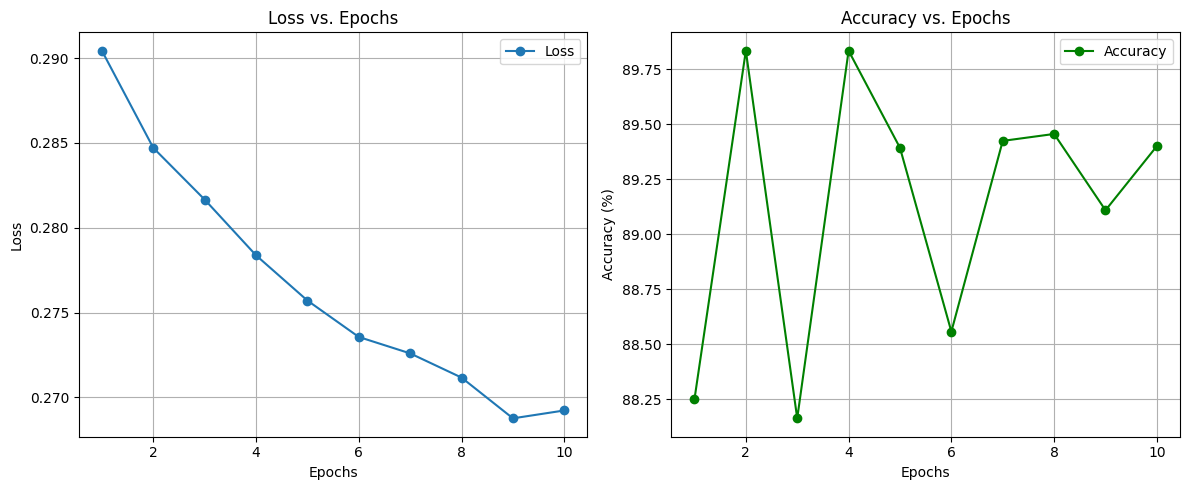

In [28]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

last_val_accuracy, best_val, history = train_utils.train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

In [4]:
plot_results(history['train_loss'], history['train_accuracy'], EPOCHS)

ImportError: cannot import name 'plot_results' from 'utils' (/Users/roeeseren/Documents/semester-seven/deep-learning/project/utils.py)

Evaluate model on test

In [42]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [43]:
print(f"Test Results: {train_utils.evaluate_model(model, test_dataloader, criterion, device)}")

Evaluation Accuracy: 90.31%


In [34]:
# Export to file
torch.save(model.state_dict(), "trained_models/rawnet_model_weights.pth")

NameError: name 'model' is not defined